Inserir dados para a Empresa 1:
Nome da Empresa: Empresa 1
Receita de vendas (faturamento): 29632
Despesa com propaganda: 9000
Número de vendedores: 8
Salário por vendedor: 1500
Custo de hora extra (ou Enter para 0): 10
Custo de estocagem (ou Enter para 0): 4
Inserir dados para a Empresa 2:
Nome da Empresa: Empresa
Receita de vendas (faturamento): 66412
Despesa com propaganda: 12000
Número de vendedores: 10
Salário por vendedor: 1500
Custo de hora extra (ou Enter para 0): 10
Custo de estocagem (ou Enter para 0): 4
Inserir dados para a Empresa 3:
Nome da Empresa: Empresa 3
Receita de vendas (faturamento): 83962
Despesa com propaganda: 15000
Número de vendedores: 12
Salário por vendedor: 1500
Custo de hora extra (ou Enter para 0): 10
Custo de estocagem (ou Enter para 0): 4
Inserir dados para a Empresa 4:
Nome da Empresa: Empresa 4
Receita de vendas (faturamento): 49854
Despesa com propaganda: 18000
Número de vendedores: 7
Salário por vendedor: 1500
Custo de hora extra (ou Enter para 0): 

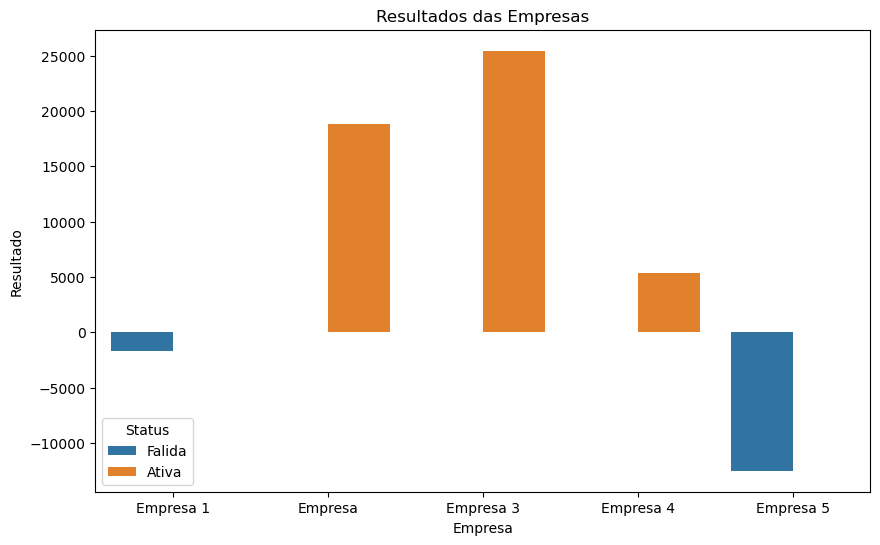

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class Empresa:
    def __init__(self, nome, receita, propaganda, num_vendedores, salario_vendedores, hora_extra, estocagem):
        self.nome = nome
        self.receita = receita
        self.propaganda = propaganda
        self.num_vendedores = num_vendedores
        self.salario_vendedores = salario_vendedores
        self.hora_extra = hora_extra
        self.estocagem = estocagem

    def calcular_despesas(self):
        salario_total = self.num_vendedores * self.salario_vendedores
        custo_hora_extra = self.hora_extra if self.hora_extra is not None else 0
        custo_estocagem = self.estocagem if self.estocagem is not None else 0

        despesas = {
            "Propaganda": self.propaganda,
            "Salário Vendedores": salario_total,
            "Hora Extra": custo_hora_extra,
            "Estocagem": custo_estocagem
        }

        return despesas

    def calcular_cmv(self):
        return 0.2 * self.receita

    def calcular_despesas_fixas(self):
        return {
            "Salários": 0.08 * self.receita,
            "Aluguel": 2000
        }

    def calcular_total_despesas(self):
        despesas = self.calcular_despesas()
        despesas_fixas = self.calcular_despesas_fixas()

        total_despesas = sum(despesas.values()) + sum(despesas_fixas.values())
        return total_despesas

    def calcular_resultado(self):
        return self.receita - self.calcular_cmv() - self.calcular_total_despesas()

    def esta_falida(self):
        return self.calcular_resultado() < 0

# Solicitar dados ao usuário para cada empresa
empresas = []
for i in range(1, 6):
    print(f"Inserir dados para a Empresa {i}:")
    nome = input("Nome da Empresa: ")
    receita = float(input("Receita de vendas (faturamento): "))
    propaganda = float(input("Despesa com propaganda: "))
    num_vendedores = int(input("Número de vendedores: "))
    salario_vendedores = float(input("Salário por vendedor: "))
    hora_extra = float(input("Custo de hora extra (ou Enter para 0): ") or 0)
    estocagem = float(input("Custo de estocagem (ou Enter para 0): ") or 0)

    empresas.append(Empresa(nome, receita, propaganda, num_vendedores, salario_vendedores, hora_extra, estocagem))

# Calculando e exibindo os resultados
resultados = []
for empresa in empresas:
    resultado = empresa.calcular_resultado()
    resultados.append(resultado)

# Classificando as empresas
classificacao = sorted(enumerate(resultados, start=1), key=lambda x: x[1])
classificacao_final = {empresa[0]: i for i, empresa in enumerate(classificacao, start=1)}

# Exibindo os resultados
print("\nDemonstrativo de Resultados")
print("Empresa\tResultado\tClassificação\tStatus")
for i, (empresa, resultado) in enumerate(zip(empresas, resultados), start=1):
    status = "Falida" if empresa.esta_falida() else "Ativa"
    print(f"{empresa.nome}\t{resultado:.2f}\t\t{classificacao_final[i]}\t\t{status}")
    
# Creating a DataFrame
data = {
    "Empresa": [empresa.nome for empresa in empresas],
    "Resultado": resultados,
    "Status": ["Falida" if empresa.esta_falida() else "Ativa" for empresa in empresas]
}
df = pd.DataFrame(data)

# Plotting a bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x="Empresa", y="Resultado", hue="Status", data=df)
plt.title("Resultados das Empresas")
plt.xlabel("Empresa")
plt.ylabel("Resultado")
plt.show()